# Confidence intervals case study using NHANES data


This notebook demonstrates how to use Python and its statistical libraries to construct confidence intervals for proportions and means.  We will also cover some important points relating to the properties of confidence intervals, and discuss how to use and interpret confidence intervals in practice.  We will use the 2015-2016 wave of the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) data for all the analyses below.

It is important to note that the NHANES data are a "complex survey".  The data are not an independent and representative sample from the target population.  Proper analysis of complex survey data should make use of additional information about the manner in which the data were collected.  Since complex survey analysis is a somewhat specialized topic, we ignore this aspect of the data here, and analyze the NHANES data as if it were an independent and identically distributed sample from a population.

The following module import statements and data reading statement are identical to what we have used previously in course 1.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [2]:
da = pd.read_csv("nhanes_2015_2016.csv")

## Confidence intervals for one proportion

In this section, we demonstrate the construction of confidence intervals for the proportion of people who smoke.  The specific definition of "smoker" used here ([SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020)) identifies a person as being a smoker if they self-report as having smoked 100 or more cigarettes in their lifetime.  It is more accurate to refer to this as a measure of "lifetime smoking" rather than "current smoking".  Recall that the definitions of these and other NHANES variables can be found using the NHANES code books, or by searching using the link below.

https://wwwn.cdc.gov/nchs/nhanes/search/default.aspx

We will calculate the proportions of smokers separately for females and for males.  Initially we can compare these two proportions and their corresponding confidence intervals informally, but later we will discuss methods to compare two proportions formally using confidence intervals.

First we replace the numeric codes in the variables of interest with text labels, and set the rare answers other than "yes" and "no" to be missing (so they will automatically be omitted from all the analyses below).

In [9]:
da["SMQ020x"]= da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

In [12]:
dx = da[["SMQ020x", "RIAGENDRx"]].dropna()
dy = pd.crosstab(index=dx.SMQ020x, columns=dx.RIAGENDRx)
dy

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


In [5]:
dx.Female.Yes

906

The confidence interval (CI) is constructed using two inputs: the sample proportion of smokers, and the total sample size for smokers and non-smokers combined.  We calculate these values next.

In [11]:
dx

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


In [13]:
dz = dx.groupby(dx.RIAGENDRx).agg({"SMQ020x": [lambda x: np.mean(x=="Yes"), np.size]})
dz

SMQ020x      
          <lambda_0>  size
RIAGENDRx                 
Female      0.304845  2972
Male        0.513258  2753

In [14]:
dz.columns = ["Proportion", "Total_n"]
dz

,Proportion,Total_n
RIAGENDRx,,
Female,0.304845,2972
Male,0.513258,2753


Confidence intervals are closely connected to standard errors.  Recall that the standard error essentially tells you how
far you should expect an estimate to fall from the truth.  A confidence interval is an interval that under repeated sampling covers the truth a defined proportion of the time.  In most settings, this "coverage probability" is set to 95%.  

It turns out that in many settings, a 95% confidence interval can be constructed as the interval consisting of all points that are within two (or 1.96) standard errors of the point estimate.  More concisely, the confidence interval approximately spans from e - 2•SE to e + 2•SE, where e is the point estimate and SE is the standard error.

Since the standard error plays such an important role here, we calculate it separately first.

In [16]:
p_f = dz.Proportion.Female                      # Value in junction of index "Female" and column "Proportion"
n_f = dz.Total_n.Female                         # Value in junction of index "Female" and column "Total_n"
se_female = np.sqrt(p_f * (1 - p_f) / n_f)      # Standard Error for Female
print("Standard Error (Female):", se_female)

p_m = dz.Proportion.Male                        # Value in junction of index "Male" and column "Total_n"
n_m = dz["Total_n"].Male                        # Value in junction of index "Male" and column "Total_n"
se_male = np.sqrt(p_m * (1 - p_m) / n_m)        # Standard Error for Male
print("Standard Error (Male):", se_male)

Standard Error (Female): 0.008444152146214435
Standard Error (Male): 0.009526078653689868


We can see that the standard errors for the estimated proportions of females and males who smoke are similar, and are each around 1% (since we are studying a proportion here, 0.01 corresponds to a 1 percentage point change in the smoking rate).  

The standard error for a proportion is maximized when the true proportion is around 1/2, and gets smaller as the true proportion approaches either 0 or 1.  The estimated male smoking proportion is closer to 1/2 than the estimated female smoking proportion, and the male sample size is smaller than the female sample size.  Both of these factors lead to the male standard error being larger than the female standard error, although the difference is very small in this case.

Next we calculate the 95% confidence intervals for the proportions of female and male smokers using the formula for the one-sample confidence interval for a proportion:

In [17]:
# For female
lcb = p_f - 1.96 * np.sqrt(p_f * (1 - p_f) / n_f)
ucb = p_f + 1.96 * np.sqrt(p_f * (1 - p_f) / n_f)
print(f"LCB = {lcb}, UCB = {ucb}")

LCB = 0.288294683866098, UCB = 0.32139576027925865


The results above indicate that any population proportion (for female lifetime smokers) between 0.288 and 0.321 would be compatible with the data that we observed in NHANES.

In [18]:
# For male
lcb = p_m - 1.96 * np.sqrt(p_m * (1 - p_m) / n_m)
ucb = p_m + 1.96 * np.sqrt(p_m * (1 - p_m) / n_m)
print(f"LCB = {lcb}, UCB = {ucb}")

LCB = 0.49458714955108174, UCB = 0.531929377873546


These results indicate that any population proportion (for male lifetime smokers) between 0.493 and 0.531 would be compatible with the NHANES data.

## Using `statsmodels`

### 95% CI for the proportion of females who smoke

In [20]:
dy.Female.Yes, dy.Female.No

(906, 2066)

In [22]:
sm.stats.proportion_confint(count=dy.Female.Yes, nobs=dy.Female.Yes+dy.Female.No)

(0.2882949879861214, 0.32139545615923526)

### 95% CI for the proportion of males who smoke

In [23]:
sm.stats.proportion_confint(count=dy.Male.Yes, nobs=dy.Male.Yes+dy.Male.No)

(0.49458749263718593, 0.5319290347874418)

## Confidence intervals comparing two independent proportions

The confidence intervals for the proportions of female and male smokers shown above are quite narrow and do not overlap.  This suggests that there is a substantial difference between the lifetime smoking rates for women and men. However there is no explicit information here about how different the two population proportions might be.  To address this question, we can form a confidence interval for the difference between the proportion of females who smoke and the proportion of males who smoke.  

The point estimate of the difference between female and male smoking rates is -0.208 (0.305 - 0.513).  That is, the smoking rate is about 20 percentage points higher in men than in women.  This difference of around 20 percentage points is only a point estimate of the underlying true value -- it is not exactly equal to the difference between the unknown proportions of females and males who smoke in the population.  A confidence interval helps us assess how far the estimated difference may be from the true difference.

As above, we start with the standard error.  The difference between two sample proportions based on independent data has a standard error that reflects the combined uncertainty in the two proportions being differenced.  This standard error can be calculated very easily.  If SE1 and SE2 are the standard errors for two proportions, then sqrt(SE1^2 + SE2^2) is the standard error for the difference of these proportions (`sqrt` is the square root function).  Note that this formula is only accurate if the two sample proportions being differenced are independent.

In the next cell we calculate the standard error for the difference between the proprotion of females who smoke and the proportion of males who smoke.

In [24]:
se_diff = np.sqrt(se_female**2 + se_male**2)
se_diff

0.012729881381407434

The standard error of around 0.013 indicates that **the estimated difference statistic -0.208 is expected to fall around 0.013 units from the true value**.  We do not know in which direction the error lies, and we do not know that the error is exactly 0.013, only that it is around this large on average.  For most purposes, a standard error of 0.013 relative to an observed difference of -0.21 would be considered very small.  That is, we have a very accurate estimate of the difference between smoking rates in women and in men.

Now that we have the standard error, we can construct a 95% confidence interval for the difference in proportions by taking the estimate and subtracting and adding two (or 1.96) standard errors from it.

In [25]:
d = dz.Proportion.Female - dz.Proportion.Male
lcb = d - 2 * se_diff
ucb = d + 2 * se_diff
print(f"LCB = {lcb}, UCB = {ucb}")

LCB = -0.2338728044024504, UCB = -0.18295327887682067


The 95% confidence interval above shows us that any value for the difference of population proportions (between females and males) lying between -0.233 and -0.183 is consistent with the observed data.

## Confidence intervals for subpopulations

Since smoking rates vary strongly with age, it might be more informative to stratify the data into homogeneous age bands and compare the proportions of female and male smokers within each age band.  We can also calculate the 95% confidence interval for this difference within each age band.  These data can be displayed as a plot, with the difference in proportions plotted as a curve.  The confidence intervals can then be used to construct a "confidence band" around the estimates.

In [26]:
# Calculate the smoking rates within age/gender groups
da["agegp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
pr = da.groupby(["agegp", "RIAGENDRx"]).agg({"SMQ020x": lambda x: np.mean(x=='Yes')})
display(pr)
pr = pr.unstack()
pr.columns = ["Female", "Male"]
display(pr)

SMQ020x
agegp    RIAGENDRx          
(18, 30] Female     0.226601
         Male       0.349265
(30, 40] Female     0.286920
         Male       0.502183
(40, 50] Female     0.268924
         Male       0.448878
(50, 60] Female     0.421277
         Male       0.572687
(60, 70] Female     0.374150
         Male       0.654462
(70, 80] Female     0.324390
         Male       0.649254

,Female,Male
agegp,,
"(18, 30]",0.226601,0.349265
"(30, 40]",0.286920,0.502183
"(40, 50]",0.268924,0.448878
"(50, 60]",0.421277,0.572687
"(60, 70]",0.374150,0.654462
"(70, 80]",0.324390,0.649254


In [27]:
# The number of people for each calculated proportion
dn = da.groupby(["agegp", "RIAGENDRx"]).agg({"SMQ020x": np.size})
display(dn)
dn = dn.unstack()
dn.columns = ["Female", "Male"]
display(dn)

SMQ020x
agegp    RIAGENDRx         
(18, 30] Female         609
         Male           544
(30, 40] Female         474
         Male           458
(40, 50] Female         502
         Male           401
(50, 60] Female         470
         Male           454
(60, 70] Female         441
         Male           437
(70, 80] Female         410
         Male           402

,Female,Male
agegp,,
"(18, 30]",609,544
"(30, 40]",474,458
"(40, 50]",502,401
"(50, 60]",470,454
"(60, 70]",441,437
"(70, 80]",410,402


In [28]:
# Standard Errors for each proportion
se = np.sqrt(pr * (1 - pr) / dn)
se

,Female,Male
agegp,,
"(18, 30]",0.016964,0.020440
"(30, 40]",0.020776,0.023363
"(40, 50]",0.019790,0.024838
"(50, 60]",0.022776,0.023217
"(60, 70]",0.023043,0.022748
"(70, 80]",0.023120,0.023801


In [34]:
# Standard Error for the difference in female/male smoking rates in every age band
se_diff = np.sqrt(se.Female**2 + se.Male**2)
se_diff

agegp
(18, 30]    0.026562
(30, 40]    0.031265
(40, 50]    0.031758
(50, 60]    0.032523
(60, 70]    0.032380
(70, 80]    0.033182
dtype: float64

In [35]:
# Standard errors for the difference in smoking rates between genders, within age bands
# The difference in smoking rates between genders
pq = pr.Female - pr.Male
pq

agegp
(18, 30]   -0.122664
(30, 40]   -0.215264
(40, 50]   -0.179954
(50, 60]   -0.151411
(60, 70]   -0.280313
(70, 80]   -0.324863
dtype: float64

In [41]:
pq.size, pq.values

(6,
 array([-0.12266372, -0.21526357, -0.1799535 , -0.15141063, -0.28031258,
        -0.32486349]))

In [36]:
x = np.arange(pq.size)
x

array([0, 1, 2, 3, 4, 5])

Text(0, 0.5, 'Female - male smoking proportion')

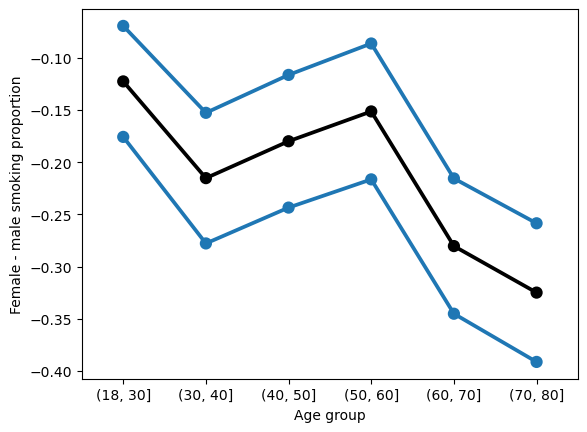

In [50]:
pp = sns.pointplot(x=x, y=pq.values, color='black')
sns.pointplot(x=x, y=pq - 2 * se_diff)
sns.pointplot(x=x, y=pq + 2 * se_diff)
pp.set_xticklabels(pq.index)
pp.set_xlabel("Age group")
pp.set_ylabel("Female - male smoking proportion")

The plot above shows for each age band, the point estimate of the difference in smoking rates between genders (black dot), and the lower and upper end points of the 95% confidence interval (blue points).  Based on this plot, we see that in the United States, smoking is more common in men than in women, not just overall, but also in every one of the age bands.  The difference is largest for older people -- for people older than 60, the smoking rate for males is around 30 percentage points greater than the smoking rate for females, while for people younger than 30, the smoking rate for males is only around 15 percentage points greater than the smoking rate for females.

Also note that the 95% confidence bands shown above are much wider than the 95% confidence intervals for the data that were not stratified by age.  Stratifying by age leads to smaller sample sizes, which in turn results in wider confidence intervals.

## Confidence intervals for the mean

In this section, we discuss how to construct confidence intervals for the mean.  First note that the proportion discussed above is also a mean -- for example, if the data are 0, 1, 0, then the mean is 1/3, which is also the proportion of 1's in the data.  However the proportion has the special property that the variance is completely determined by the mean. That is why we constructed the standard errors for the sample proportion above using p•(1 - p) as the variance.  In general, the variance of quantitative data will not be a function of the mean, as this is a very special property of binary data.  Therefore, in general we must estimate the variance as a separate step after estimating the mean. 

To illustrate the construction of confidence intervals for the population mean of a quantitative variable, we will use the body mass inde (BMI) data from NHANES.  To begin, we calculate the mean BMI for all women and for all men in the NHANES sample.

In [ ]:
da.groupby